easyocr



In [ ]:
!pip uninstall triton
!pip install --upgrade pip setuptools wheel
!pip install easyocr



  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached python_bidi-0.6.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached pyclipper-1.3.0.post6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.0 kB)
  Using cached ninja-1.11.1.3-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curan

In [ ]:
import cv2
import easyocr
import numpy as np
import json

# Пути к файлам
IMAGE_PATH = "/content/drive/MyDrive/AI_guide/Изображения/plan_upscale_bw.jpg"
OUTPUT_JSON = "/content/drive/MyDrive/AI_guide/graph_plan_easyocr_2.json"

# Загружаем изображение
image = cv2.imread(IMAGE_PATH)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Используем EasyOCR для извлечения текста
reader = easyocr.Reader(['en'], gpu=True)  # Поддержка английского и русского
results = reader.readtext(gray)

# Собираем узлы
nodes = []
for bbox, text, conf in results:
    x1, y1 = int(bbox[0][0]), int(bbox[0][1])  # Верхний левый угол
    x2, y2 = int(bbox[2][0]), int(bbox[2][1])  # Нижний правый угол
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2  # Центр надписи

    nodes.append({"id": text.strip(), "x": center_x, "y": center_y})

# Определяем рёбра (связи) на основе линий в изображении
edges = []
edged = cv2.Canny(gray, 50, 150)
lines = cv2.HoughLinesP(edged, 1, np.pi/180, 50, minLineLength=30, maxLineGap=10)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        node1 = min(nodes, key=lambda n: (n['x'] - x1) ** 2 + (n['y'] - y1) ** 2)
        node2 = min(nodes, key=lambda n: (n['x'] - x2) ** 2 + (n['y'] - y2) ** 2)
        if node1 != node2:
            dist = int(np.sqrt((node1['x'] - node2['x'])**2 + (node1['y'] - node2['y'])**2))
            edges.append({"from": node1['id'], "to": node2['id'], "distance": dist})

# Сохранение в JSON
graph = {"nodes": nodes, "edges": edges}
with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(graph, f, indent=4, ensure_ascii=False)

print(f"Граф успешно сохранён в {OUTPUT_JSON}")


Граф успешно сохранён в /content/drive/MyDrive/AI_guide/graph_plan_easyocr_2.json


In [ ]:
import cv2
import easyocr
import numpy as np
import json
IMAGE_PATH = "/content/drive/MyDrive/AI_guide/Изображения/b&w.png"
image = cv2.imread(IMAGE_PATH)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
import numpy as np

with open("/content/drive/MyDrive/AI_guide/graph_plan_easyocr.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)
nodes = graph_data['nodes']
edges = []
edged = cv2.Canny(gray, 50, 150)
lines = cv2.HoughLinesP(edged, 1, np.pi/180, 50, minLineLength=30, maxLineGap=10)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        node1 = min(nodes, key=lambda n: (n['x'] - x1) ** 2 + (n['y'] - y1) ** 2)
        node2 = min(nodes, key=lambda n: (n['x'] - x2) ** 2 + (n['y'] - y2) ** 2)
        if node1 != node2:
            dist = int(np.sqrt((node1['x'] - node2['x'])**2 + (node1['y'] - node2['y'])**2))
            edges.append({"from": node1['id'], "to": node2['id'], "distance": dist})

In [ ]:
graph = {"nodes": nodes, "edges": edges}
OUTPUT_JSON = "/content/drive/MyDrive/AI_guide/graph_easyocr_new.json"
with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(graph, f, indent=4, ensure_ascii=False)

print(f"Граф успешно сохранён в {OUTPUT_JSON}")


Граф успешно сохранён в /content/drive/MyDrive/AI_guide/graph_easyocr_new.json


In [ ]:
import numpy as np
import cv2
import json

# Загрузка данных графа
with open("/content/drive/MyDrive/AI_guide/graph_plan_easyocr.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

nodes = graph_data['nodes']
edges = []

# Загружаем изображение для анализа стен
image_path = "/content/drive/MyDrive/AI_guide/Изображения/b&w.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Читаем в оттенках серого
edged = cv2.Canny(image, 50, 150)  # Применяем детектор границ

# Функция для проверки, есть ли стена между двумя точками
def is_blocked(x1, y1, x2, y2, edged_image):
    # Проверка на пересечение с границами (стенами)
    line = cv2.line(np.zeros_like(edged_image), (x1, y1), (x2, y2), 255, 1)
    intersection = cv2.bitwise_and(line, edged_image)
    return np.any(intersection > 0)  # Если есть пересечение, значит, есть стена

# Ищем линии на изображении с помощью Hough-преобразования
lines = cv2.HoughLinesP(edged, 1, np.pi / 180, 50, minLineLength=30, maxLineGap=10)

# Проверяем связи между узлами
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Ищем ближайшие узлы к найденным точкам
        node1 = min(nodes, key=lambda n: (n['x'] - x1) ** 2 + (n['y'] - y1) ** 2)
        node2 = min(nodes, key=lambda n: (n['x'] - x2) ** 2 + (n['y'] - y2) ** 2)

        # Проверяем, не являются ли узлы одинаковыми
        if node1 != node2:
            # Проверяем, есть ли стена между этими узлами
            if not is_blocked(node1['x'], node1['y'], node2['x'], node2['y'], edged):
                dist = int(np.sqrt((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2))
                edges.append({"from": node1['id'], "to": node2['id'], "distance": dist})

# Сохраняем ребра в граф
graph_data['edges'] = edges

# Сохраняем обновленный граф обратно в JSON
with open("/content/drive/MyDrive/AI_guide/graph_easyocr_new.json", "w", encoding="utf-8") as f:
    json.dump(graph_data, f, ensure_ascii=False, indent=4)


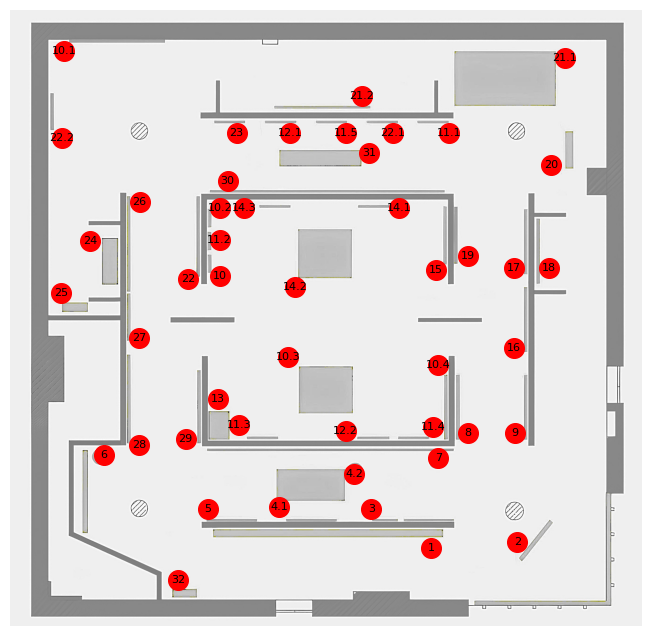

In [ ]:
import cv2
import matplotlib.pyplot as plt
import networkx as nx
import json

image_path = "/content/drive/MyDrive/AI_guide/Изображения/plan_upscale_bw.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open("/content/drive/MyDrive/AI_guide/graph_plan_easyocr.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

G = nx.Graph()
for node in graph_data["nodes"]:
    G.add_node(node["id"], pos=(node["x"], node["y"]))
plt.figure(figsize=(12, 8))
plt.imshow(image)

pos = {node["id"]: (node["x"], node["y"]) for node in graph_data["nodes"]}

nx.draw(G, pos, with_labels=True, node_color="red", edge_color="blue", node_size=200, font_size=8)

plt.show()


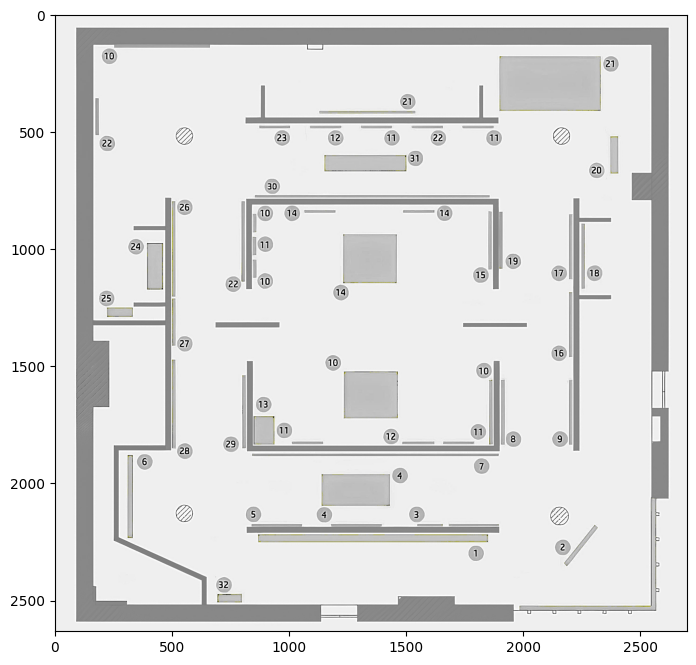

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(image)

paddleocr

In [ ]:
!pip install paddlepaddle paddleocr


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 116.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114298 sha256=dda8bdeb30e76e4527f9d5f6590317f995e2bccd660224eb4d6b53ff18d607cf
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0


In [ ]:
import cv2
import matplotlib.pyplot as plt
import networkx as nx
import json

# Загрузите изображение карты
image_path = "/content/drive/MyDrive/AI_guide/Изображения/plan_upscale_bw.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразуем для matplotlib

# Загрузите граф из JSON
with open("/content/drive/MyDrive/AI_guide/graph_paddleocr.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

# Создаем граф
G = nx.Graph()
for node in graph_data["nodes"]:
    G.add_node(node["id"], pos=(node["x"], node["y"]))
# Рисуем изображение
plt.figure(figsize=(12, 8))
plt.imshow(image)

# Получаем координаты узлов
pos = {node["id"]: (node["x"], node["y"]) for node in graph_data["nodes"]}

# Рисуем граф поверх изображения
nx.draw(G, pos, with_labels=True, node_color="red", edge_color="blue", node_size=200, font_size=8)

plt.show()


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


без нейронок

прошлое

In [ ]:
pos=(node["x"], node["y"])
print(pos)

(719, 2433)


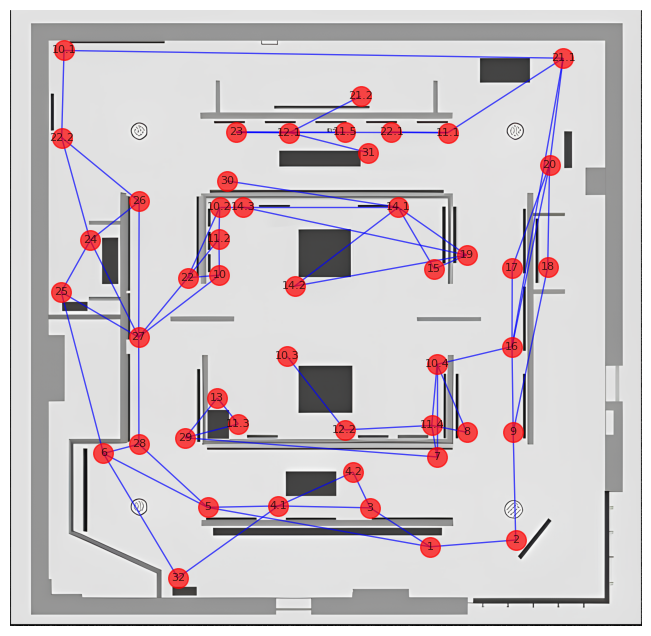

In [ ]:
import cv2
import matplotlib.pyplot as plt
import networkx as nx
import json

# Путь к изображению
image_path = "/content/drive/MyDrive/AI_guide/Изображения/b&w.png"

# Загружаем изображение
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Загружаем данные графа
with open("/content/drive/MyDrive/AI_guide/graph_easyocr_edges.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

# Создаем граф
G = nx.Graph()

# Добавляем узлы
for node in graph_data["nodes"]:
    G.add_node(node["id"], pos=(node["x"], node["y"]))

# Если в данных есть информация о рёбрах, добавляем их
for edge in graph_data["edges"]:
    G.add_edge(edge["from"], edge["to"])

# Получаем позиции узлов
pos = {node["id"]: (node["x"], node["y"]) for node in graph_data["nodes"]}

# Отображаем график
plt.figure(figsize=(12, 8))
plt.imshow(image)

# Настройки отображения графа
nx.draw(G, pos, with_labels=True, node_color="red", edge_color="blue", node_size=200, font_size=8, alpha=0.7)


plt.show()


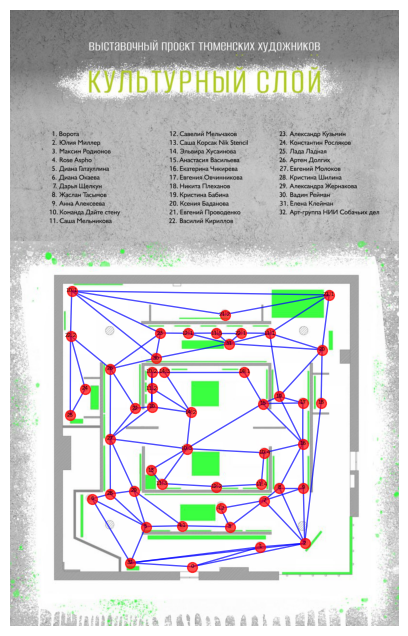

In [ ]:
import cv2
import matplotlib.pyplot as plt
import networkx as nx
import json

# Путь к изображению
image_path = "/content/drive/MyDrive/AI_guide/5438406694389543051.jpg"

# Загружаем изображение
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Загружаем данные графа
with open("/content/drive/MyDrive/AI_guide/graph_with_titles.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

# Создаем граф
G = nx.Graph()

# Добавляем узлы
for node in graph_data["nodes"]:
    G.add_node(node["id"], pos=(node["x"], node["y"]))

# Если в данных есть информация о рёбрах, добавляем их
for edge in graph_data["edges"]:
    G.add_edge(edge["from"], edge["to"])

# Получаем позиции узлов
pos = {node["id"]: (node["x"], node["y"]) for node in graph_data["nodes"]}

# Уменьшаем координаты (сжимаем граф в два раза)
scale_factor = 0.25
pos_scaled = {node_id: (x * scale_factor, y * scale_factor) for node_id, (x, y) in pos.items()}

# Сдвигаем граф вниз (увеличиваем Y-координаты) и вправо (увеличиваем X-координаты)
y_offset = 540  # смещение вниз (можно регулировать по желанию)
x_offset = 70  # смещение вправо (можно регулировать по желанию)
pos_scaled_offset = {node_id: (x + x_offset, y + y_offset) for node_id, (x, y) in pos_scaled.items()}

# Отображаем график
plt.figure(figsize=(12, 8))
plt.imshow(image)

# Настройки отображения графа
nx.draw(G, pos=pos_scaled_offset, with_labels=True, node_color="red", edge_color="blue", node_size=50, font_size=4, alpha=0.7)

plt.show()


In [ ]:
# Обновляем координаты узлов в исходных данных
for node in graph_data["nodes"]:
    new_x, new_y = pos_scaled_offset[node["id"]]
    node["x"] = new_x
    node["y"] = new_y

# Сохраняем обновлённый JSON в новый файл
output_path = "/content/drive/MyDrive/AI_guide/graph_easyocr_transformed_1.json"
with open(output_path, "w", encoding="utf-8") as f_out:
    json.dump(graph_data, f_out, ensure_ascii=False, indent=2)

print(f"Обновлённый граф сохранён в {output_path}")


Обновлённый граф сохранён в /content/drive/MyDrive/AI_guide/graph_easyocr_transformed_1.json


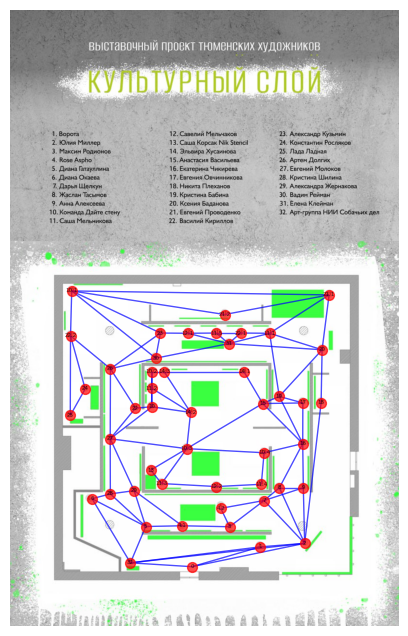

In [ ]:
import cv2
import matplotlib.pyplot as plt
import networkx as nx
import json

# Путь к изображению
image_path = "/content/drive/MyDrive/AI_guide/route.jpg"

# Загружаем изображение
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Загружаем данные графа
with open("/content/drive/MyDrive/AI_guide/graph_easyocr_transformed.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

# Создаем граф
G = nx.Graph()

# Добавляем узлы
for node in graph_data["nodes"]:
    G.add_node(node["id"], pos=(node["x"], node["y"]))

# Если в данных есть информация о рёбрах, добавляем их
for edge in graph_data["edges"]:
    G.add_edge(edge["from"], edge["to"])

# Получаем позиции узлов
pos = {node["id"]: (node["x"], node["y"]) for node in graph_data["nodes"]}

# Отображаем график
plt.figure(figsize=(12, 8))
plt.imshow(image)

# Настройки отображения графа
nx.draw(G, pos, with_labels=True, node_color="red", edge_color="blue", node_size=50, font_size=4, alpha=0.7)

plt.savefig('save.jpg', dpi=300, bbox_inches='tight', pad_inches=0)



In [ ]:
import cv2
import matplotlib.pyplot as plt
import networkx as nx
import json

def draw_route_only(route_nodes, graph_json_path, background_image_path, output_image_path):
    """
    Отображает только вершины и рёбра, входящие в маршрут, и сохраняет изображение для отправки в Telegram.

    :param route_nodes: список id узлов маршрута (например, ['0', '23', '14', ...])
    :param graph_json_path: путь к JSON-файлу с графом
    :param background_image_path: путь к изображению фона
    :param output_image_path: путь, куда сохранить изображение
    """
    # Загружаем изображение
    image = cv2.imread(background_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Загружаем граф
    with open(graph_json_path, "r", encoding="utf-8") as f:
        graph_data = json.load(f)

    # Строим граф
    G = nx.Graph()
    for node in graph_data["nodes"]:
        G.add_node(node["id"], pos=(node["x"], node["y"]))

    for edge in graph_data["edges"]:
        G.add_edge(edge["from"], edge["to"])

    # Получаем позиции всех узлов
    pos = nx.get_node_attributes(G, "pos")

    # Создаем подграф с нужными вершинами
    route_subgraph = nx.Graph()
    for i in range(len(route_nodes) - 1):
        u, v = route_nodes[i], route_nodes[i + 1]
        if G.has_edge(u, v):
            route_subgraph.add_edge(u, v)

    # Добавляем одиночные вершины, если они без рёбер
    for node_id in route_nodes:
        if node_id not in route_subgraph.nodes:
            route_subgraph.add_node(node_id)

    # Рисуем изображение
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    nx.draw(route_subgraph,
            pos,
            with_labels=True,
            node_color="#8b00ff",
            edge_color="orange",
            node_size=200,
            font_size=7,
            width=6,
            font_color="white"
            )

    # Сохраняем изображение
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_image_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

    print(f"✅ Изображение маршрута сохранено: {output_image_path}")
# Пример маршрута
route_nodes = ['0', '23', '14.1', '8', '0']

# Пути к файлам
graph_json_path = "/content/drive/MyDrive/AI_guide/graph_easyocr_transformed.json"
background_image_path = "/content/drive/MyDrive/AI_guide/route.jpg"
output_image_path = "/content/drive/MyDrive/AI_guide/route_for_telegram.jpg"

draw_route_only(route_nodes, graph_json_path, background_image_path, output_image_path)


✅ Изображение маршрута сохранено: /content/drive/MyDrive/AI_guide/route_for_telegram.jpg


In [ ]:
import numpy as np
import json

node1_id = "17"
node2_id = "22.1"

with open("/content/drive/MyDrive/AI_guide/graph_easyocr_new.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

nodes = {node["id"]: node for node in graph_data["nodes"]}

if node1_id in nodes and node2_id in nodes:
    node1, node2 = nodes[node1_id], nodes[node2_id]

    dist = int(np.sqrt((node1['x'] - node2['x'])**2 + (node1['y'] - node2['y'])**2))
    edge_data = {
        "from": node1_id,
        "to": node2_id,
        "distance": dist
    }
    print(json.dumps(edge_data, indent=4, ensure_ascii=False))

else:
    print("Ошибка: одна или обе вершины отсутствуют в графе")


{
    "from": "17",
    "to": "22.1",
    "distance": 778
}


In [ ]:
import json
with open("/content/drive/MyDrive/AI_guide/graph_easyocr_new.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

nodes = {node["id"]: node for node in graph_data["nodes"]}

# Сортируем id в порядке возрастания
sorted_nodes = sorted(nodes, key=lambda x: float(x))

# Выводим результат
print(sorted_nodes)

['1', '2', '3', '4.1', '4.2', '5', '6', '7', '8', '9', '10', '10.1', '10.2', '10.3', '10.4', '11.1', '11.2', '11.3', '11.4', '11.5', '12.1', '12.2', '13', '14.1', '14.2', '14.3', '15', '16', '17', '18', '19', '20', '21.1', '21.2', '22', '22.1', '22.2', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


In [ ]:
graph_json_path = "/content/drive/MyDrive/AI_guide/graph_easyocr_new.json"
titles_json_path = "/content/drive/MyDrive/AI_guide/nodes_with_titles.json"
output_json_path = "/content/drive/MyDrive/AI_guide/graph_with_titles.json"

# Загружаем JSON с графом
with open(graph_json_path, "r", encoding="utf-8") as f:
    graph_data = json.load(f)

graph_data.keys()

dict_keys(['nodes', 'edges'])

In [ ]:
import json
import networkx as nx

In [ ]:
with open('/content/drive/MyDrive/AI_guide/graph_easyocr_transformed_1.json', "r", encoding="utf-8") as f:
    graph_data = json.load(f)
print(graph_data.keys())

dict_keys(['nodes', 'edges'])


In [ ]:
import json

# Пути к файлам
graph_json_path = "/content/drive/MyDrive/AI_guide/graph_easyocr_new.json"
titles_json_path = "/content/drive/MyDrive/AI_guide/nodes_with_titles.json"
output_json_path = "/content/drive/MyDrive/AI_guide/graph_with_titles.json"

# Загружаем JSON с графом
with open(graph_json_path, "r", encoding="utf-8") as f:
    graph_data = json.load(f)

# Загружаем JSON с названиями
with open(titles_json_path, "r", encoding="utf-8") as f:
    titles_data = json.load(f)

# Создаём словарь {id: title} для быстрого поиска
titles_dict = {item["id"]: item["title"] for item in titles_data}

# Добавляем title в вершины графа
for node in graph_data["nodes"]:
    node_id = node["id"]
    if node_id in titles_dict:
        node["title"] = titles_dict[node_id]

# Сохраняем обновленный граф
with open(output_json_path, "w", encoding="utf-8") as f:
    json.dump(graph_data, f, ensure_ascii=False, indent=4)

print(f"Файл {output_json_path} сохранён!")


Файл /content/drive/MyDrive/AI_guide/graph_with_titles.json сохранён!


In [ ]:
import json
import pandas as pd

# Загружаем данные
data_df = pd.read_csv("/content/drive/MyDrive/AI_guide/Slovcova_new_data_format.csv")  # Таблица с title и nodes

# Преобразуем nodes из строк в список
nodes_with_titles = []

for _, row in data_df.iterrows():
    node_list = json.loads(row["nodes"]) if isinstance(row["nodes"], str) else []  # Декодируем JSON-список
    for node in node_list:
        nodes_with_titles.append({"id": node, "title": row["title"]})

# Сохраняем в JSON
with open("/content/drive/MyDrive/AI_guide/nodes_with_titles.json", "w", encoding="utf-8") as f:
    json.dump(nodes_with_titles, f, ensure_ascii=False, indent=4)

print("Файл nodes_with_titles.json сохранён!")


Файл nodes_with_titles.json сохранён!


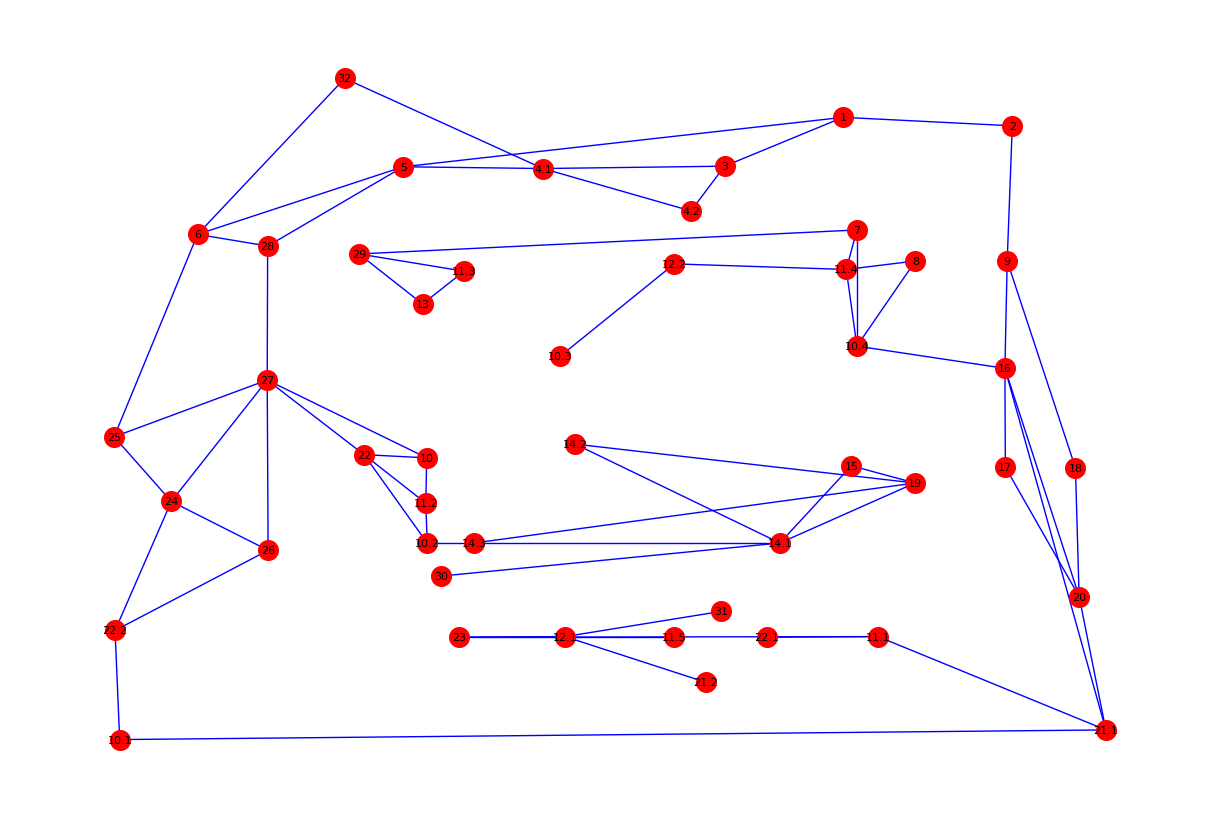

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import json

# Загрузите граф из JSON
with open("/content/drive/MyDrive/AI_guide/graph_easyocr_edges.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

# Создаем граф
G = nx.Graph()
for node in graph_data["nodes"]:
    G.add_node(node["id"], pos=(node["x"], node["y"]))

for edge in graph_data["edges"]:
    G.add_edge(edge["from"], edge["to"], weight=edge["distance"])

# Получаем координаты узлов
# Рисуем граф
plt.figure(figsize=(12, 8))
pos = {node["id"]: (node["x"], node["y"]) for node in graph_data["nodes"]}
nx.draw(G, pos, with_labels=True, node_color="red", edge_color="blue", node_size=200, font_size=8)

plt.show()


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/AI_guide/Slovcova_embeddings_2.parquet')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 30
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       30 non-null     object
 1   text        30 non-null     object
 2   embeddings  30 non-null     object
 3   image       0 non-null      object
dtypes: object(4)
memory usage: 2.2+ KB


In [ ]:
found = any(node["id"] == "RoseAspho_2" for node in graph_data["nodes"])
print("RoseAspho_2 в JSON:", found)

RoseAspho_2 в JSON: True


In [ ]:
image_path = "/content/drive/MyDrive/AI_guide/without_text.png"
map_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, binary_map = cv2.threshold(map_image, 200, 255, cv2.THRESH_BINARY)

In [ ]:
with open("/content/drive/MyDrive/AI_guide/graph_numbers.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

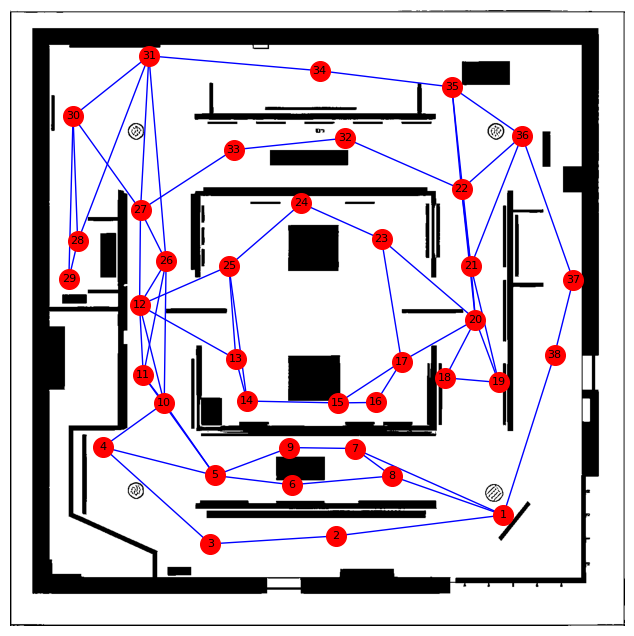

In [ ]:
import cv2
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# === 1. ЗАГРУЗКА ДАННЫХ ===
# Загрузка карты (ч/б, где стены - черные, проходы - белые)
image_path = "/content/drive/MyDrive/AI_guide/without_text.png"
map_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, binary_map = cv2.threshold(map_image, 200, 255, cv2.THRESH_BINARY)
# Загрузка списка узлов из JSON
with open("/content/drive/MyDrive/AI_guide/graph_numbers.json", "r", encoding="utf-8") as f:
    graph_data = json.load(f)

nodes = graph_data["nodes"]
G = nx.Graph()

# Добавляем узлы в граф
for node in nodes:
    G.add_node(node["id"], pos=(node["x"], node["y"]))

# === 2. ФУНКЦИЯ ПРОВЕРКИ СТЕН ===
def is_path_clear(x1, y1, x2, y2, image):
    """ Проверяет, можно ли провести путь между точками (x1, y1) и (x2, y2), не наткнувшись на стену. """
    line = np.linspace([x1, y1], [x2, y2], num=100)  # Генерируем 100 точек по прямой
    for point in line.astype(int):
        if image[point[1], point[0]] == 0:  # Если пиксель черный (стена) → путь заблокирован
            return False
    return True

# === 3. ПОСТРОЕНИЕ ГРАФА ===
# Создаём KD-дерево для быстрого поиска ближайших узлов
points = np.array([(node["x"], node["y"]) for node in nodes])
tree = KDTree(points)

# Определяем соседей (например, 5 ближайших)
k_neighbors = 8  # Количество соседей
for i, node in enumerate(nodes):
    x1, y1 = node["x"], node["y"]

    # Находим ближайшие узлы
    dists, indices = tree.query([x1, y1], k=k_neighbors + 1)  # +1, потому что первый - сам узел

    for j, idx in enumerate(indices[1:]):  # Пропускаем самого себя
        x2, y2 = nodes[idx]["x"], nodes[idx]["y"]

        # Если путь свободен - добавляем ребро
        if is_path_clear(x1, y1, x2, y2, binary_map):
            G.add_edge(node["id"], nodes[idx]["id"], weight=dists[j + 1])  # dist[j+1], т.к. [0] - это сам узел

# === 4. ИСПРАВЛЕНИЕ КООРДИНАТ ===
height = binary_map.shape[0]  # Получаем высоту изображения
# pos = {node["id"]: (node["x"], height - node["y"]) for node in nodes}  # Отражаем Y-координаты

# === 5. ВИЗУАЛИЗАЦИЯ ===
plt.figure(figsize=(12, 8))
plt.imshow(binary_map, cmap="gray")  # Показываем ЧБ-карту
nx.draw(G, pos, with_labels=True, node_color="red", edge_color="blue", node_size=200, font_size=8)

plt.show()


In [ ]:
import json
import networkx as nx

def load_graph(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    G = nx.Graph()
    for node in data["nodes"]:
        G.add_node(node["id"], x=node["x"], y=node["y"], title=node["title"])
    for edge in data["edges"]:
        G.add_edge(edge["from"], edge["to"], weight=edge["distance"])
    return G


In [ ]:
def draw_route_on_map(G, route, image_path, output_path, map_area_height_ratio=0.5, scale_factor=1/3.5, shift_x=450, shift_y=230):
    import cv2

    map_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    h, w = map_img.shape[:2]

    # Масштабирование с учетом квадратной карты
    graph_x_min = min(G.nodes[n]['x'] for n in G.nodes)
    graph_x_max = max(G.nodes[n]['x'] for n in G.nodes)
    graph_y_min = min(G.nodes[n]['y'] for n in G.nodes)
    graph_y_max = max(G.nodes[n]['y'] for n in G.nodes)

    usable_h = int(h * map_area_height_ratio)

    # Масштабирование графа в 3 раза (уменьшение на 1/3)
    scale_x = (w / (graph_x_max - graph_x_min)) * scale_factor
    scale_y = (usable_h / (graph_y_max - graph_y_min)) * scale_factor

    # Дополнительный сдвиг по вертикали для размещения графа в нижней части изображения
    shift_y = h - usable_h + shift_y  # Добавляем дополнительный сдвиг по вертикали
    shift_x = shift_x  # Добавляем сдвиг по горизонтали

    def scale_coords(x, y):
        # Масштабируем координаты
        sx = int((x - graph_x_min) * scale_x) + shift_x  # Сдвигаем по горизонтали
        sy = int((y - graph_y_min) * scale_y) + shift_y  # Сдвигаем по вертикали
        return sx, sy

    # Получаем координаты для маршрута
    coords = [scale_coords(G.nodes[n]['x'], G.nodes[n]['y']) for n in route]

    # Рисуем точки маршрута
    for i, (x, y) in enumerate(coords):
        cv2.circle(map_img, (x, y), 10, (0, 0, 255), -1)
        cv2.putText(map_img, str(i + 1), (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

    # Рисуем линии маршрута
    for i in range(len(coords) - 1):
        cv2.line(map_img, coords[i], coords[i + 1], (0, 255, 0), 2)

    # Сохраняем результат
    cv2.imwrite(output_path, map_img)


In [ ]:
graph_path = "/content/drive/MyDrive/AI_guide/graph_with_titles.json"
image_path = "/content/drive/MyDrive/AI_guide/5438406694389543051.jpg"
output_path = "/content/drive/MyDrive/AI_guide/map_with_route.png"

G = load_graph(graph_path)
example_route = ['0', '1', '5', '9', '0']  # Пример маршрута

draw_route_on_map(G, example_route, image_path, output_path)


In [ ]:
def csv_to_parquet(input_csv, output_parquet, column_to_remove):
    # Читаем CSV-файл в DataFrame
    df = pd.read_csv(input_csv)

    # Проверяем, есть ли столбец в DataFrame и удаляем его
    if column_to_remove in df.columns:
        df = df.drop(columns=[column_to_remove])
    else:
        print(f"Столбец '{column_to_remove}' не найден в файле.")

    # Сохраняем DataFrame в формате Parquet
    df.to_parquet(output_parquet, index=False)
    print(f"Файл сохранён в формате Parquet: {output_parquet}")

# Пример использования
csv_to_parquet("/content/drive/MyDrive/AI_guide/Slovcova_new_data_format (1).csv", "/content/drive/MyDrive/AI_guide/Slovcova_new.parquet", "edges")

Файл сохранён в формате Parquet: /content/drive/MyDrive/AI_guide/Slovcova_new.parquet


Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer
# from datasets import Dataset
import pandas as pd
import torch

# df = pd.read_parquet('/content/drive/MyDrive/AI_guide/Slovcova_new.parquet')
# df.info()
# data = Dataset.from_pandas(df)

model_emb = SentenceTransformer("BAAI/bge-m3")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_emb.to(device)

def get_embeddings(text_list):
    embeddings = model_emb.encode(
        text_list, convert_to_tensor=True, #device=device
    )
    return embeddings

# embeddings_dataset = data.map(
#     lambda x:{"embeddings": get_embeddings(x["text"]).cpu().numpy()}
# )

# embeddings_dataset.to_parquet('/content/drive/MyDrive/AI_guide/Slovcova_embeddings_map.parquet')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet('/content/Slovcova_embeddings_map_img.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              34 non-null     object
 1   text               34 non-null     object
 2   short_description  34 non-null     object
 3   image              34 non-null     object
 4   nodes              34 non-null     object
 5   embeddings         34 non-null     object
dtypes: object(6)
memory usage: 1.7+ KB


In [ ]:
df['embeddings'][33]

array([-0.00242112,  0.0236474 , -0.06240676, ...,  0.02562074,
       -0.01955065,  0.00114566], dtype=float32)

In [ ]:
data = data[data["title"] != "Ворота"]

In [ ]:
model_emb.encode(text, convert_to_tensor=True).cpu().numpy()

In [ ]:
text = "Ворота: Ворота – это не просто архитектурный элемент, а настоящий символ перехода в неизведанное. Эти ворота, привезенные из села Нижняя Тавда, хранят в себе вековую историю, полную тайн и воспоминаний. С древнейших времен ворота олицетворяли вход в новое пространство, таинственную силу и скрытые миры. Они служат мостом между привычным и неизведанным, открывая двери в мир, где творчество встречается с реальностью. Каждый раз, проходя мимо них, мы погружаемся в уникальный культурный слой Тюменского региона. История этих ворот насыщена множеством событий. Их не раз перевозили вместе с домом, и каждый переезд оставил свой след. Каждая деталь рассказывает свою собственную историю жизни. После их прибытия в музей команда опытных реставраторов начала кропотливую работу по восстановлению. Специалисты тщательно изучили каждую деталь, чтобы сохранить аутентичность и оригинальный облик ворот. Реставрация включала очистку, восстановление поврежденных элементов и укрепление конструкции. Благодаря этому процессу ворота обрели вторую жизнь, сохранив все свои исторические особенности. Теперь эти ворота стали центральным экспонатом новой выставки современного искусства «Культурный слой». За ними простирается мир художников и арт-групп, где обыденность трансформируется в искусство. Здесь каждое произведение – это не просто объект для восприятия, а повод задуматься о нашем взаимодействии с окружающим пространством. Тюменские художники используют неожиданные материалы и образы, чтобы подчеркнуть контраст между привычным и необычным. Ворота символизируют не только вход, но и таинственные миры. Они открывают путь в новое понимание того, что значит быть частью разнообразного культурного слоя.  Смотря на эти ворота, вы открываете новые горизонты, где реальность смешивается с фантазией. Добро пожаловать в мир современного искусства, где каждый шаг – это шаг к новому пониманию культуры и искусства."
embedding_vector = get_embeddings(text).cpu().numpy()

In [ ]:
embedding_vector

array([-0.00848587,  0.00983836, -0.05721372, ..., -0.01466022,
       -0.00627765, -0.01833526], dtype=float32)

In [ ]:
new_row = {
    "title": "Ворота",
    "text": "Ворота: Ворота – это не просто архитектурный элемент, а настоящий символ перехода в неизведанное. Эти ворота, привезенные из села Нижняя Тавда, хранят в себе вековую историю, полную тайн и воспоминаний. С древнейших времен ворота олицетворяли вход в новое пространство, таинственную силу и скрытые миры. Они служат мостом между привычным и неизведанным, открывая двери в мир, где творчество встречается с реальностью. Каждый раз, проходя мимо них, мы погружаемся в уникальный культурный слой Тюменского региона. История этих ворот насыщена множеством событий. Их не раз перевозили вместе с домом, и каждый переезд оставил свой след. Каждая деталь рассказывает свою собственную историю жизни. После их прибытия в музей команда опытных реставраторов начала кропотливую работу по восстановлению. Специалисты тщательно изучили каждую деталь, чтобы сохранить аутентичность и оригинальный облик ворот. Реставрация включала очистку, восстановление поврежденных элементов и укрепление конструкции. Благодаря этому процессу ворота обрели вторую жизнь, сохранив все свои исторические особенности. Теперь эти ворота стали центральным экспонатом новой выставки современного искусства «Культурный слой». За ними простирается мир художников и арт-групп, где обыденность трансформируется в искусство. Здесь каждое произведение – это не просто объект для восприятия, а повод задуматься о нашем взаимодействии с окружающим пространством. Тюменские художники используют неожиданные материалы и образы, чтобы подчеркнуть контраст между привычным и необычным. Ворота символизируют не только вход, но и таинственные миры. Они открывают путь в новое понимание того, что значит быть частью разнообразного культурного слоя.  Смотря на эти ворота, вы открываете новые горизонты, где реальность смешивается с фантазией. Добро пожаловать в мир современного искусства, где каждый шаг – это шаг к новому пониманию культуры и искусства.",
    "short_description": "Ворота: Ворота – это не просто архитектурный элемент, а настоящий символ перехода в неизведанное. Эти ворота, привезенные из села Нижняя Тавда, хранят в себе вековую историю, полную тайн и воспоминаний. С древнейших времен ворота олицетворяли вход в новое пространство, таинственную силу и скрытые миры. Они служат мостом между привычным и неизведанным, открывая двери в мир, где творчество встречается с реальностью. Каждый раз, проходя мимо них, мы погружаемся в уникальный культурный слой Тюменского региона. История этих ворот насыщена множеством событий. Их не раз перевозили вместе с домом, и каждый переезд оставил свой след. Каждая деталь рассказывает свою собственную историю жизни. После их прибытия в музей команда опытных реставраторов начала кропотливую работу по восстановлению. Специалисты тщательно изучили каждую деталь, чтобы сохранить аутентичность и оригинальный облик ворот. Реставрация включала очистку, восстановление поврежденных элементов и укрепление конструкции. Благодаря этому процессу ворота обрели вторую жизнь, сохранив все свои исторические особенности. Теперь эти ворота стали центральным экспонатом новой выставки современного искусства «Культурный слой». За ними простирается мир художников и арт-групп, где обыденность трансформируется в искусство. Здесь каждое произведение – это не просто объект для восприятия, а повод задуматься о нашем взаимодействии с окружающим пространством. Тюменские художники используют неожиданные материалы и образы, чтобы подчеркнуть контраст между привычным и необычным. Ворота символизируют не только вход, но и таинственные миры. Они открывают путь в новое понимание того, что значит быть частью разнообразного культурного слоя.  Смотря на эти ворота, вы открываете новые горизонты, где реальность смешивается с фантазией. Добро пожаловать в мир современного искусства, где каждый шаг – это шаг к новому пониманию культуры и искусства.",
    "image": "https://drive.google.com/file/d/1FdIvnQ_4r5OQ7aKJPOcxXP2klX7Z3KQW/view?usp=drive_link",
    "nodes": [1],
    "embeddings": embedding_vector
}

In [ ]:
data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
data['embeddings'][1]

array([-0.0530825 , -0.00184753, -0.00384658, ...,  0.02174005,
        0.01533714,  0.0482941 ], dtype=float32)

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.head(2)

,title,text,short_description,image,nodes,embeddings
0,Дайте стену,"«ДАЙТЕ СТЕНУ»\nКоманда художников, стрит-артис...","«ДАЙТЕ СТЕНУ»\nКоманда художников, стрит-артис...",https://drive.google.com/file/d/1HvAoibjqaHvK5...,"[10, 10.1, 10.2, 10.3, 10.4]","[-0.01470209, 0.017413104, -0.04517646, 0.0266..."
1,Мельникова,САША МЕЛЬНИКОВА\nМультисдисциплинарный художни...,САША МЕЛЬНИКОВА\nМультисдисциплинарный художни...,https://drive.google.com/file/d/1YUGxTF3uhhxk_...,"[11.1, 11.2, 11.3, 11.4, 11.5]","[-0.053082503, -0.0018475263, -0.0038465767, 0..."


In [ ]:
data = pd.read_parquet('/content/Slovcova_embeddings_map_img.parquet')

In [ ]:
data = data[data["title"] != "Ворота"]

In [ ]:
data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              34 non-null     object
 1   text               34 non-null     object
 2   short_description  34 non-null     object
 3   image              34 non-null     object
 4   nodes              34 non-null     object
 5   embeddings         34 non-null     object
dtypes: object(6)
memory usage: 1.7+ KB


In [ ]:
print(data.dtypes)

title                object
text                 object
short_description    object
image                object
nodes                object
embeddings           object
dtype: object


In [ ]:
for col in data.select_dtypes(include=['object']):
    print(f"Column: {col}")
    print(data[col].apply(type).value_counts())

Column: title
title
<class 'str'>    34
Name: count, dtype: int64
Column: text
text
<class 'str'>    34
Name: count, dtype: int64
Column: short_description
short_description
<class 'str'>    34
Name: count, dtype: int64
Column: image
image
<class 'str'>    34
Name: count, dtype: int64
Column: nodes
nodes
<class 'str'>    34
Name: count, dtype: int64
Column: embeddings
embeddings
<class 'numpy.ndarray'>    34
Name: count, dtype: int64


In [ ]:
data['nodes'] = data['nodes'].apply(lambda x: str(x) if isinstance(x, list) else x)

In [ ]:
data.to_parquet('/content/Slovcova_embeddings_map_img_1.parquet', index=False)

ArrowTypeError: ("Expected bytes, got a 'list' object", 'Conversion failed for column nodes with type object')

In [ ]:
data['embeddings'][1]

array([-0.0530825 , -0.00184753, -0.00384658, ...,  0.02174005,
        0.01533714,  0.0482941 ], dtype=float32)

In [ ]:
data['embeddings'][33]

'[-0.00848587  0.00983836 -0.05721372 ... -0.01466022 -0.00627765\n -0.01833526]'

In [ ]:
import ast

In [ ]:
df = pd.read_parquet('/content/Slovcova_embeddings_map_img_1.parquet')

In [ ]:
df['embeddings'][1]

array([-0.0530825 , -0.00184753, -0.00384658, ...,  0.02174005,
        0.01533714,  0.0482941 ], dtype=float32)